<a href="https://colab.research.google.com/github/rflameiro/Python_e_Quiminformatica/blob/main/Quiminformatica/Espa%C3%A7o_qu%C3%ADmico_proje%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Espaço químico é um conceito usado para se referir a um conjunto de estruturas químicas. Podemos imaginar que seja possível distribuir esses compostos em um "espaço N-dimensional", ou seja, cada estrutura é representada por um vetor de N dimensões nesse espaço. Dessa forma, vemos que o espaço químico não é único, e está relacionado com a forma que representamos os compostos químicos [1](https://www.tandfonline.com/doi/full/10.1080/17460441.2022.2084608).

A ideia de espaço químico pode ser usada em diferentes contextos, por exemplo: o espaço químico de fármacos aprovados (contém alguns milhares de compostos, e o número aumenta a cada ano), o espaço químico de moléculas disponíveis comercialmente (alguns bilhões) ou o espaço químico de moléculas com possível interesse farmacológico (um número comumente citado é 10 elevado a 60 compostos [2](https://pubs.acs.org/doi/10.1021/ar500432k)\). Dessa forma, podemos dizer que quando estamos buscando novos compostos para uma aplicação, estamos explorando o espaço químico.

Em geral, quando precisamos criar uma representação visual do espaço químico, precisamos cumprir duas etapas:

1. Representar as estruturas moleculares como vetores numéricos. Estes podem ser [descritores físico-químicos](https://github.com/rflameiro/Python_e_Quiminformatica/blob/main/Quiminformatica/Calculando%20descritores.ipynb) ou *fingerprints* moleculares, por exemplo.
2. Converter esses vetores numéricos de N dimensões para duas ou três dimensões, criando em seguida um gráfico em que cada ponto representa um composto químico, chamado de projeção.

Para a segunda etapa, diversas transformações estão disponíveis, e cada uma fornece um resultado diferente, uma vez que não há uma forma única de reduzir a dimensionalidade de vetores. Uma das principais é a [análise de componentes principais](https://pt.wikipedia.org/wiki/An%C3%A1lise_de_componentes_principais), ou PCA. Outros métodos mais recentes, como MDS, t-SNE e UMAP cumprem o mesmo propósito de reduzir a dimensionalidade dos dados. Os métodos t-SNE e UMAP, por exemplo, tendem a agrupar melhor pontos similares. Adicionei mais explicações nas subseções abaixo.

Neste Notebook, vamos mostrar como gerar essas projeções, possibilitando localizar estruturas químicas em um espaço bidimensional, criando assim visualizações de um espaço químico. Vamos usar um conjunto de dados com estruturas de antibióticos como exemplo. Começaremos calculando descritores físico-químicos e *fingerprints* moleculares para compostos pertencentes a duas classes de antibióticos. Em seguida, visualizaremos o espaço químico desses compostos utilizando diferentes métodos, e discutiremos alguns aspectos das visualizações.

In [1]:
# Montar drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Instalar e importar módulos

In [2]:
%%capture
!pip install rdkit
!pip install umap-learn

In [3]:
# Versões dos módulos
# Python
import sys
print('Python: {}'.format(sys.version))
# matplotlib
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
# numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
# rdkit
import rdkit
print('rdkit: {}'.format(rdkit.__version__))
import umap
print('umap: {}'.format(umap.__version__))

Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
matplotlib: 3.7.1
numpy: 1.25.2
pandas: 2.0.3
rdkit: 2024.03.1
umap: 0.5.6


In [4]:
import matplotlib.pyplot as plt

# Módulos para calcular descritores
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, rdFingerprintGenerator
from rdkit.ML.Descriptors import MoleculeDescriptors

# Módulos/funções para fazer as projeções
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import umap

# Importar conjunto de dados e calcular descritores

In [5]:
# Conjunto de dados com nomes de antibióticos, estruturas e suas classes
# O arquivo .csv está disponível na pasta datasets do GitHub
url = "https://raw.githubusercontent.com/rflameiro/Python_e_Quiminformatica/main/datasets/antibiotics_SMILES.csv"
df = pd.read_csv(url)
df.head()

,name,class,SMILES
0,Amikacin,aminoglycosides,NCC[C@H](O)C(=O)N[C@@H]1C[C@H](N)[C@@H](O[C@H]...
1,Gentamicin,aminoglycosides,CNC(C)C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(NC...
2,Kanamycin,aminoglycosides,NC[C@H]1O[C@H](O[C@@H]2[C@@H](N)C[C@@H](N)[C@H...
3,Neomycin,aminoglycosides,NC[C@@H]1O[C@H](O[C@@H]2[C@@H](CO)O[C@@H](O[C@...
4,Netilmicin,aminoglycosides,CCN[C@@H]1C[C@H](N)[C@@H](O[C@H]2OC(CN)=CC[C@H...


In [6]:
# Vamos manter apenas as duas classes de antibióticos com mais compostos
df = df[df['class'].isin(['quinolones/fluoroquinolones', 'penicillins'])].copy()
df.shape

(34, 3)

In [7]:
# Criar uma lista com uma cor para cada classe para colorir os plots
cores = ['red' if val == 'penicillins' else 'blue' for val in df['class']]

In [8]:
# Converter SMILES a RDKit Mol
df["rdkit_mol"] = df["SMILES"].apply(Chem.MolFromSmiles)

In [9]:
%%capture
# Calcular descritores físico-químicos do RDKit
# Com esse código, todos os descritores disponíveis no RDKit são calculados e
# os descritores principais ficam nas primeiras colunas do DataFrame
main_descs = ["MolLogP", "MolWt", "NumAromaticRings", "NumHAcceptors",
              "NumHDonors", "NumRotatableBonds", "FractionCSP3", "TPSA"]
names = [name[0] for name in Descriptors.descList if name[0] not in main_descs]
names = main_descs + names
calc = MoleculeDescriptors.MolecularDescriptorCalculator(names)
lista_descritores = [calc.CalcDescriptors(m) for m in df["rdkit_mol"]]
df_descritores = pd.DataFrame(lista_descritores, columns=names)
df_descritores.head()

In [10]:
# Calcular fingerprints Morgan com 1024 bits e raio = 3
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=1024)

lista_fps = [mfpgen.GetFingerprintAsNumPy(m) for m in df["rdkit_mol"]]
df_fps = pd.DataFrame(lista_fps, columns=[str(i) for i in range(1,1025)])
df_fps.head()

,1,2,3,4,5,6,7,8,9,10,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


# Espaço químico - descritores

## Usando apenas os oito descritores principais

In [11]:
# Selecionar as colunas correspondentes aos oito descritores
df_desc_principais = df_descritores.loc[:, main_descs].copy()

# Normalizar os dados - importante para PCA
df_normalized = (df_desc_principais - df_desc_principais.mean()) / df_desc_principais.std()
df_normalized.head()

,MolLogP,MolWt,NumAromaticRings,NumHAcceptors,NumHDonors,NumRotatableBonds,FractionCSP3,TPSA
0,-1.514491,-0.414906,-1.238884,0.136568,2.330432,0.126975,0.356209,1.130511
1,-1.203922,-0.679446,-1.238884,-0.792094,1.031503,0.126975,0.356209,0.372872
2,-1.440119,1.173906,-1.238884,0.136568,2.330432,0.990407,0.512440,1.699396
3,-1.026274,-0.200036,-1.238884,-0.792094,1.031503,0.990407,0.034556,0.795322
4,1.149203,0.750433,0.321192,0.136568,-0.267427,0.126975,-0.507174,0.373246


In [12]:
# Remover colunas com erro no cálculo dos descritores, caso existam
df_normalized = df_normalized.dropna(axis='columns')

In [13]:
X = df_normalized.copy()

### PCA

O método PCA não precisa de nenhum argumento, e usa como entrada apenas a matriz de descritores. Porém, é importante normalizar os dados antes de fazer uma projeção com PCA, caso contrário, variáveis com valores numéricos maiores se sobrepõem às outras. Para manter o padrão, vamos usar a matriz normalizada para calcular todas as projeções.

O método PCA pode reduzir os dados para qualquer número de dimensões menor que o original. Cada uma das novas dimensões é chamada de componente principal, sendo que o primeiro componente principal (PC1) corresponde à combinação linear de descritores com a maior variância. A PC2 é ortogonal à PC1 e é a segunda combinação com maior variância, sucessivamente, até PCn.

Veja mais sobre redução de dimensionalidade [neste Notebook](https://github.com/rflameiro/Python_e_Quiminformatica/blob/main/Machine_Learning/Sele%C3%A7%C3%A3o%20de%20vari%C3%A1veis%20e%20Redu%C3%A7%C3%A3o%20de%20dimensionalidade.ipynb).

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

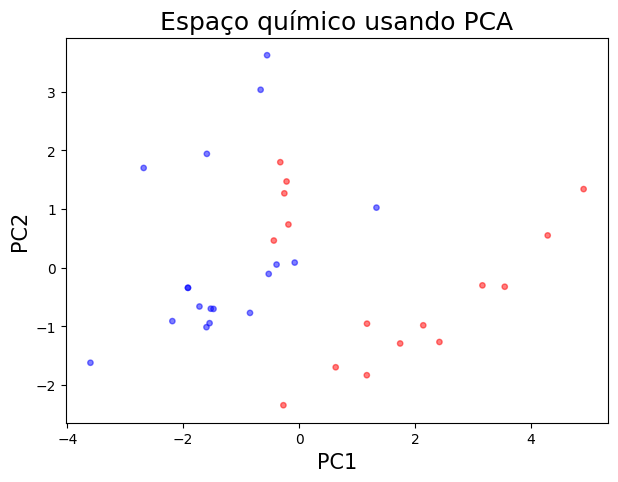

In [15]:
# Plot
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=15, c=cores, alpha=0.5)
plt.title('Espaço químico usando PCA', fontsize=18)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.show()

### MDS

Do inglês *Multidimensional Scaling*, compreende uma série de métodos que buscam representar a similaridade entre objetos como distâncias em um espaço de menos dimensões, preservando as distâncias relativas entre os objetos no espaço multidimensional original. Em outras palavras: dada uma matriz contendo a distância (ou dissimilaridade) entre os objetos em m-dimensões, encontre uma projeção em n-dimensões (n < m) que preserva essas distâncias, sendo o número final de dimensões pré-definido pelo usuário (geralmente 2 ou 3). O método clássico de MDS, do qual o método PCA é um caso particular, emprega distâncias Euclidianas.

Os algoritmos para MDS podem ser separados em métricos, que usam uma transformação linear da matriz de dissimilaridades, considerando que a distância entre os pontos deve ser proporcional à sua dissimilaridade, e não-métricos, que usam uma transformação monotônica da matriz de dissimilaridades, buscando preservar a ordem entre as distâncias, ou seja, são usados quando não estamos interessados nos valores das distâncias, mas apenas na sua ordem (*ranking*). Em geral, a MDS métrica é a que usamos, pois desejamos em preservar em 2D as distâncias observadas em N-dimensões.

Ao criar um gráfico usando MDS é importante reportar a medida de distância empregada para o cálculo de dissimilaridades, o valor de *stress* (um número que indica o quanto as distâncias na projeção diferem das distâncias na tabela de similaridade – quanto mais próximo de zero, melhor o ajuste), e o algoritmo utilizado. Nos exemplos abaixo, todos os valores de *stress* ficaram altos, indicando que houve muita perda de informação na redução de dimensionalidade (o que é esperado, já que precisamos projetar os dados em duas dimensões para criar as visualizações).

Os parâmetros mais importantes na implementação do scikit-learn são:
- `n_components`: Número final de dimensões.
- `metric`: True para fazer MDS métrica, False para não-métrica. O padrão é True.
- `dissimilarity`: Indica se estamos fornecendo os vetores e desejamos usar a distância Euclidiana ("euclidean") ou a matriz de dissimilaridades pré-computada ("precomputed"). O padrão é "euclidean".

Veja outros parâmetros disponíveis [neste link, em inglês](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html).


In [16]:
mds = MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    normalized_stress="auto",
    random_state=0
)

# Declaramos normalized_stress para evitar um warning do scikit-learn, mas ele
# não terá nenhum impacto para a MDS métrica
X_mds = mds.fit_transform(X)

In [17]:
# valor final do stress
mds.stress_

177.34726344436496

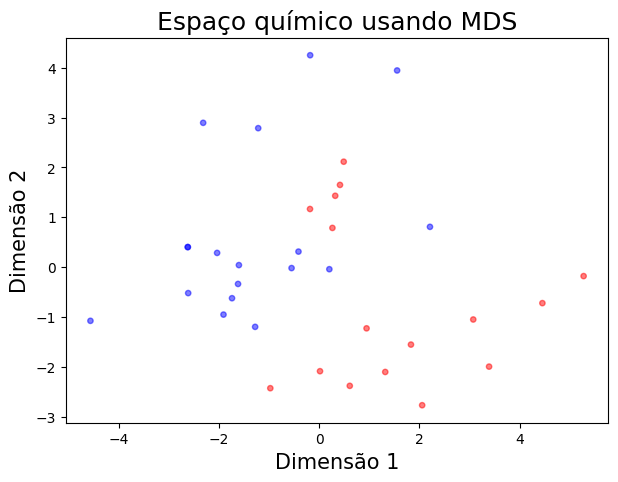

In [18]:
# Plot
plt.figure(figsize=(7,5))
plt.scatter(X_mds[:,0], X_mds[:,1], s=15, c=cores, alpha=0.5)
plt.title('Espaço químico usando MDS', fontsize=18)
plt.xlabel('Dimensão 1', fontsize=15)
plt.ylabel('Dimensão 2', fontsize=15)
plt.show()

### t-SNE

Do inglês *t-Distributed Stochastic Neighbour Embedding*, o método t-SNE procura preservar a estrutura local (pontos mais agrupados são mostrados próximos entre si), enquanto a distância entre esses agrupamentos pode não ter significado real.

[Este site](https://observablehq.com/@robstelling/abrindo-a-caixa-preta-do-t-sne/2) descreve com detalhes o funcionamento do método t-SNE. Estes são alguns dos parâmetros importantes que podem ser ajustados (texto traduzido da [documentação](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE) e retirado [deste blog](https://www.ibm.com/docs/pt-br/cloud-paks/cp-data/4.8.x?topic=types-t-sne-charts)\):

- `n_components`: Número final de dimensões.
- `perplexity` (Perplexidade): Número que indica uma estimativa do número de vizinhos próximos para cada ponto. Seu propósito é equilibrar os aspectos locais e globais da projeção. Conjuntos de dados maiores geralmente exigem uma perplexidade maior. Considere selecionar um valor entre 5 e 50. Valores diferentes podem resultar em resultados significativamente diferentes. A perplexidade deve ser menor que o número de amostras.
- `early_exaggeration`: Controla o quão compactos os clusters naturais no espaço original estão no espaço projetado e quanto espaço haverá entre eles. Para valores maiores, o espaço entre os clusters naturais será maior no espaço projetado.
- `learning_rate` (Taxa de aprendizado): Afeta a velocidade do aprendizado; se for muito baixo, pode demorar muito para o algoritmo atingir a convergência, enquanto se for muito alto, o método será incapaz de fazer um ajuste fino, e o resultado final provavelmente não será ideal.
- `metric`: Medida usada para computar as distâncias. Por exemplo, distância Euclidiana ("euclidean") ou índice de Tanimoto ("jaccard"). Note que apesar do mesmo nome, o uso é diferente do MDS. Veja [aqui](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) outras métricas disponíveis.
- `init`: Controla a inicialização da projeção, ou seja, a posição inicial dos pontos. Pode ser aleatória ("random") ou usando uma projeção feita por PCA ("pca"). A inicialização PCA não pode ser usada com distâncias pré-computadas e geralmente é mais estável globalmente do que a inicialização aleatória.

Veja outros parâmetros disponíveis [neste link, em inglês](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE)

In [19]:
perplexities = [2, 5, 10]  # deve ser menor que o número de amostras

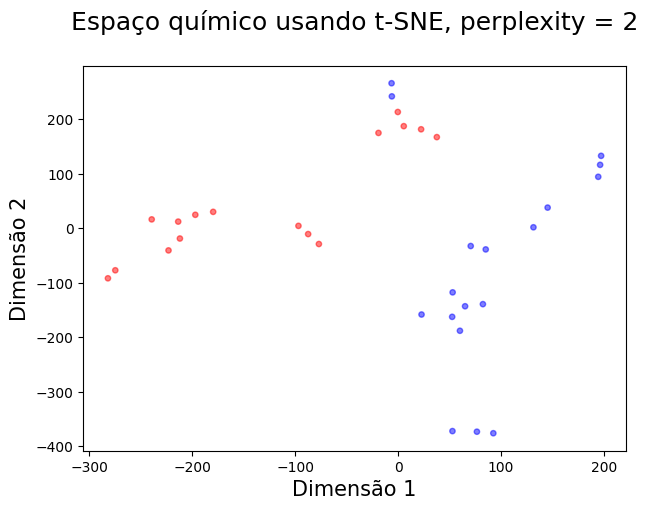

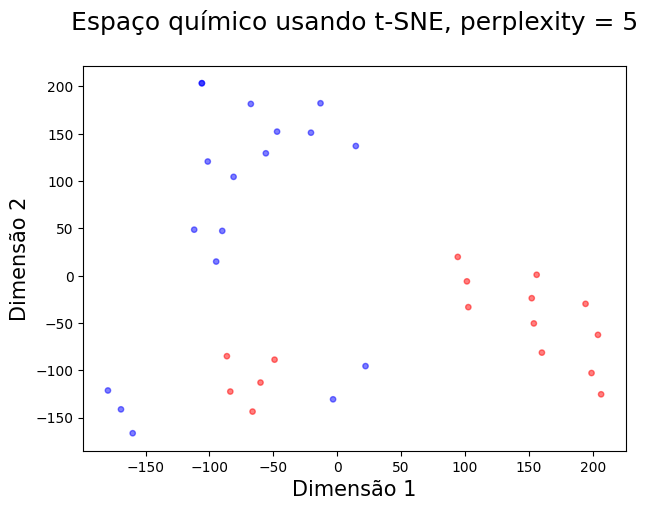

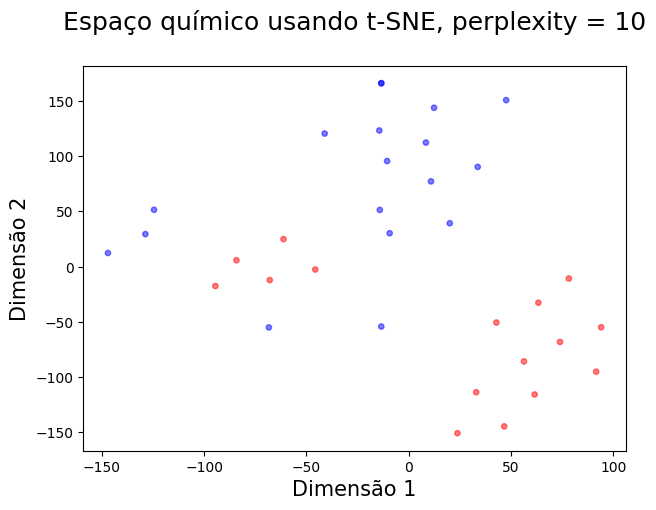

In [20]:
for perplexity in perplexities:
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate="auto",
        metric="euclidean",
        init="pca",
        random_state=0
    )
    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(7,5))
    plt.scatter(X_tsne[:,0], X_tsne[:,1], s=15, c=cores, alpha=0.5)
    plt.title(f'Espaço químico usando t-SNE, perplexity = {str(perplexity)}\n', fontsize=18)
    plt.xlabel('Dimensão 1', fontsize=15)
    plt.ylabel('Dimensão 2', fontsize=15)
    plt.show()

### UMAP

O método UMAP foi desenvolvido com o objetivo de ser uma versão melhorada do t-SNE, buscando criar visualizações que também reflitam a estrutura global, além da local, com menos tempo de cálculo.

Como exemplo, podemos pensar em dados referentes a países: enquanto o método t-SNE será capaz de agrupar os países de acordo com os continentes, o método UMAP será capaz de fazer isso, além de posicionar os grupos na posição correta, por exemplo, a Ásia mais perto da Europa do que da América do Sul. Os principais parâmetros que definem o gráfico obtido pelo método UMAP, na implementação Python, são:

- `n_neighbors`: Para valores menores, o método tentará preservar estruturas locais, em detrimento da global. Amostras muito parecidas são agrupadas, mas perdemos as relações entre grupos. Deve ser menor que o número total de amostras.
- `min_dist`: Indica a distância mínima permitida entre os pontos dentro de um agrupamento. Valores menores indicam que não estamos interessados na estrutura interna dos agrupamentos, e o modelo provavelmente agrupará todas as amostras em um espaço muito pequeno.
- `n_components`: A dimensionalidade para a qual queremos reduzir nosso espaço. Para visualização, os valores 2 ou 3 são adotados. Para fins de agrupamento (por exemplo, usando o algoritmo HBDSCAN), valores maiores podem ser empregados, com o objetivo de perder menos informação.
- `metric`: Medida usada para computar as distâncias. Por exemplo, distância Euclidiana ("euclidean") ou índice de Tanimoto ("jaccard"). Note que apesar do mesmo nome, o uso é diferente do MDS.
- `init`: Controla a inicialização da projeção, ou seja, a posição inicial dos pontos. Além das opções disponíveis no t-SNE, aleatória ("random") e PCA ("pca"), também existem mais duas: "spectral" e "tswspectral", sendo a última recomendada caso a "spectral" demore muito para terminar.  

Veja outros parâmetros [neste link, em inglês](https://umap-learn.readthedocs.io/en/latest/parameters.html) e [neste, também em inglês](https://umap-learn.readthedocs.io/en/latest/api.html).


In [21]:
n_neighbors_list = [2, 5, 10]

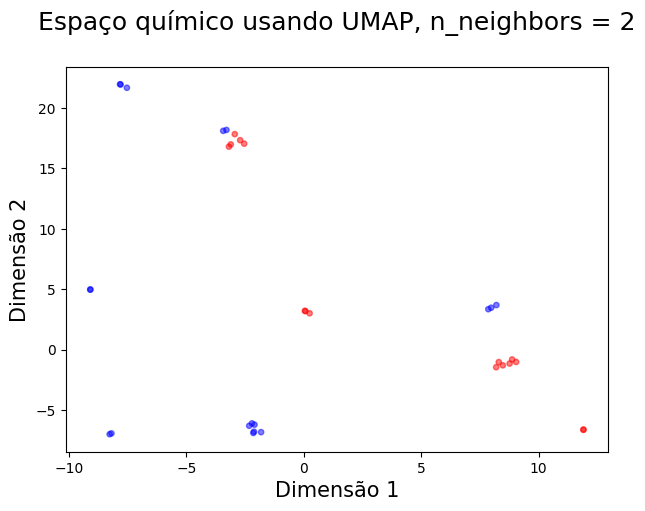

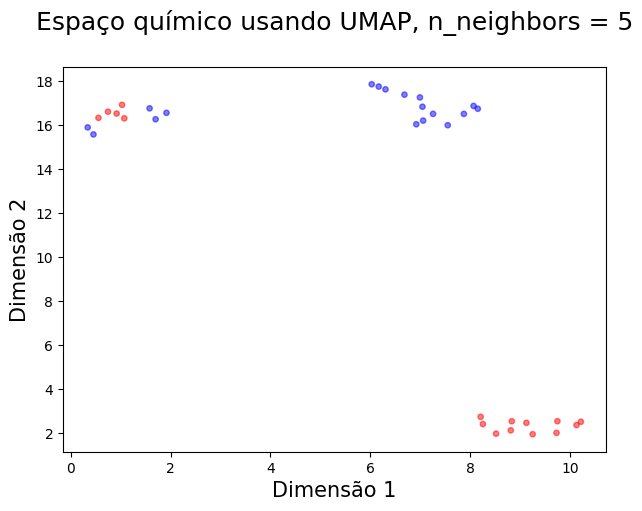

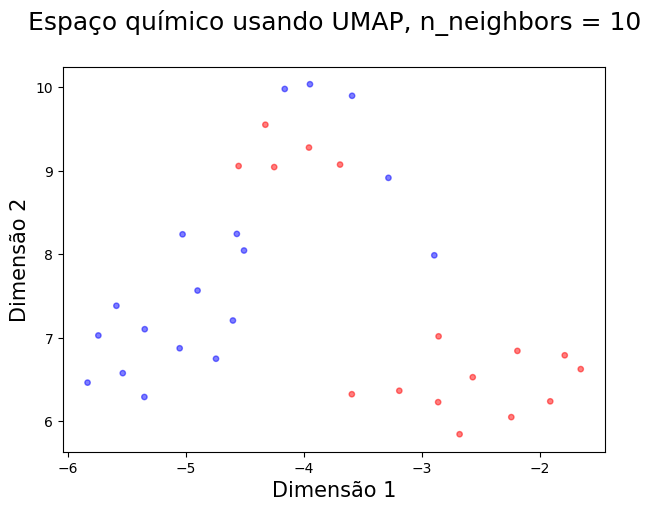

In [22]:
for n in n_neighbors_list:
    reducer = umap.UMAP(
        n_neighbors=n,
        n_components=2,
        metric="euclidean",
        init="spectral",
        random_state=0,
        n_jobs=1
    )
    X_umap = reducer.fit_transform(X)

    plt.figure(figsize=(7,5))
    plt.scatter(X_umap[:,0], X_umap[:,1], s=15, c=cores, alpha=0.5)
    plt.title(f'Espaço químico usando UMAP, n_neighbors = {str(n)}\n', fontsize=18)
    plt.xlabel('Dimensão 1', fontsize=15)
    plt.ylabel('Dimensão 2', fontsize=15)
    plt.show()

### Comentários

Note que em nenhum dos gráficos conseguimos separar completamente as duas classes de antibióticos (pontos de cores diferentes "se misturam" em algumas regiões). Dessa forma, parece que usando apenas oito descritores para descrever nossos compostos químicos obtemos uma sobreposição significativa entre as classes.

Em um exemplo prático, suponha que você observasse esse mesmo fenômeno se estivesse tentando criar um modelo de classificação. Essa sobreposição poderia indicar que não seria simples treinar um bom modelo de classificação com esses descritores, e alguns compostos seriam classificados incorretamente pois são mais "parecidos" com a classe oposta àquela que pertencem.

Podemos criar outro exemplo hipotético. Repare que, no último gráfico usando UMAP, há uma boa separação, mas cinco compostos "vermelhos" estão misturados com os "azuis". Suponha que os pontos vermelhos representem fármacos aprovados para uso humano, enquanto os azuis são compostos ativos contra um parasito, e que estamos interessados em reposicionar fármacos para tratar a parasitose em questão. Em outras palavras, estamos interessados em encontrar compostos "vermelhos" que sejam parecidos com os "azuis". Nesse caso, poderíamos começar investigando esses cinco compostos "vermelhos" que parecem estar mais próximos do espaço químico dos "azuis".

Vamos ver agora qual o impacto de usar todos os descritores disponíveis no RDKit (mais de 200).




## Usando todos os descritores do RDKit

Quando usamos muitos descritores e o número de amostras é grande, pode ser importante ajustar outros parâmetros no caso das projeções t-SNE e UMAP, para aumentar a chance de conversão. No caso, como temos poucas amostras, vou manter os mesmos parâmetros usados anteriormente.

In [23]:
# Normalizar os dados - importante para PCA
df_normalized = (df_descritores - df_descritores.mean()) / df_descritores.std()
df_normalized.head()

,MolLogP,MolWt,NumAromaticRings,NumHAcceptors,NumHDonors,NumRotatableBonds,FractionCSP3,TPSA,MaxAbsEStateIndex,MaxEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-1.514491,-0.414906,-1.238884,0.136568,2.330432,0.126975,0.356209,1.130511,-1.305849,-1.305849,...,0.985184,-0.171499,NaN,NaN,NaN,NaN,NaN,-0.246296,NaN,-0.293856
1,-1.203922,-0.679446,-1.238884,-0.792094,1.031503,0.126975,0.356209,0.372872,-1.317264,-1.317264,...,0.985184,-0.171499,NaN,NaN,NaN,NaN,NaN,-0.246296,NaN,-0.293856
2,-1.440119,1.173906,-1.238884,0.136568,2.330432,0.990407,0.512440,1.699396,-0.621885,-0.621885,...,0.985184,-0.171499,NaN,NaN,NaN,NaN,NaN,-0.246296,NaN,3.702584
3,-1.026274,-0.200036,-1.238884,-0.792094,1.031503,0.990407,0.034556,0.795322,-1.166299,-1.166299,...,0.985184,-0.171499,NaN,NaN,NaN,NaN,NaN,-0.246296,NaN,-0.293856
4,1.149203,0.750433,0.321192,0.136568,-0.267427,0.126975,-0.507174,0.373246,-0.752377,-0.752377,...,0.985184,-0.171499,NaN,NaN,NaN,NaN,NaN,-0.246296,NaN,-0.293856


In [24]:
# Remover colunas com erro no cálculo dos descritores, caso existam
df_normalized = df_normalized.dropna(axis='columns')

In [25]:
df_normalized.head()

,MolLogP,MolWt,NumAromaticRings,NumHAcceptors,NumHDonors,NumRotatableBonds,FractionCSP3,TPSA,MaxAbsEStateIndex,MaxEStateIndex,...,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_piperdine,fr_piperzine,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_thiophene,fr_urea
0,-1.514491,-0.414906,-1.238884,0.136568,2.330432,0.126975,0.356209,1.130511,-1.305849,-1.305849,...,-0.171499,5.659453,5.659453,-0.306477,-0.775139,-0.930503,0.985184,-0.171499,-0.246296,-0.293856
1,-1.203922,-0.679446,-1.238884,-0.792094,1.031503,0.126975,0.356209,0.372872,-1.317264,-1.317264,...,-0.171499,-0.171499,-0.171499,-0.306477,-0.775139,-0.930503,0.985184,-0.171499,-0.246296,-0.293856
2,-1.440119,1.173906,-1.238884,0.136568,2.330432,0.990407,0.512440,1.699396,-0.621885,-0.621885,...,-0.171499,-0.171499,-0.171499,-0.306477,-0.775139,-0.930503,0.985184,-0.171499,-0.246296,3.702584
3,-1.026274,-0.200036,-1.238884,-0.792094,1.031503,0.990407,0.034556,0.795322,-1.166299,-1.166299,...,-0.171499,-0.171499,-0.171499,-0.306477,-0.775139,-0.930503,0.985184,-0.171499,-0.246296,-0.293856
4,1.149203,0.750433,0.321192,0.136568,-0.267427,0.126975,-0.507174,0.373246,-0.752377,-0.752377,...,-0.171499,-0.171499,-0.171499,-0.306477,-0.775139,-0.930503,0.985184,-0.171499,-0.246296,-0.293856


In [26]:
X = df_normalized.copy()

### PCA

In [27]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

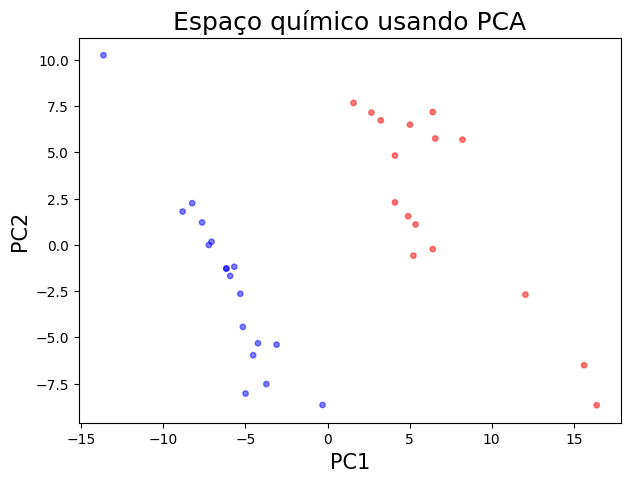

In [28]:
# Plot
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=15, c=cores, alpha=0.5)
plt.title('Espaço químico usando PCA', fontsize=18)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.show()

### MDS

In [29]:
mds = MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    normalized_stress="auto",
    random_state=0
)

X_mds = mds.fit_transform(X)

In [30]:
# valor final do stress
mds.stress_

8790.448296712722

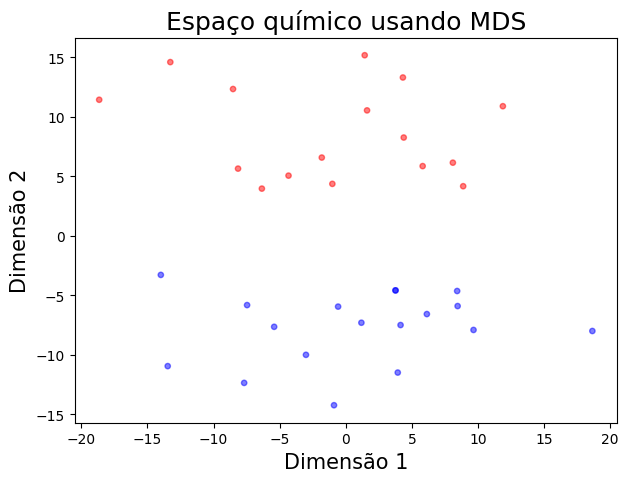

In [31]:
# Plot
plt.figure(figsize=(7,5))
plt.scatter(X_mds[:,0], X_mds[:,1], s=15, c=cores, alpha=0.5)
plt.title('Espaço químico usando MDS', fontsize=18)
plt.xlabel('Dimensão 1', fontsize=15)
plt.ylabel('Dimensão 2', fontsize=15)
plt.show()

### t-SNE

In [32]:
perplexities = [2, 5, 10]  # deve ser menor que o número de amostras

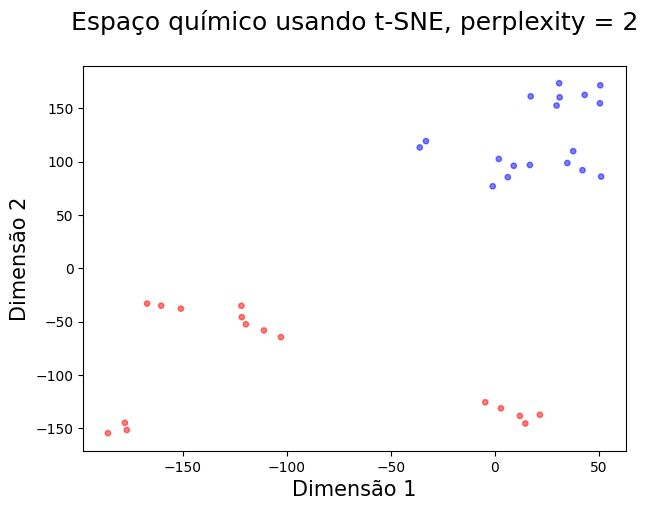

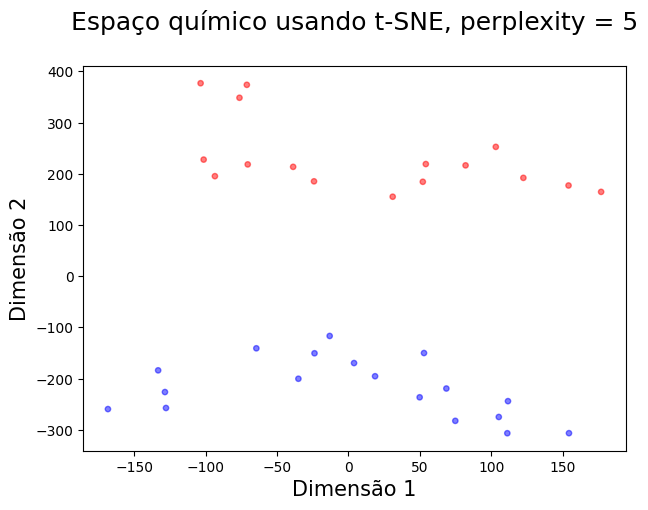

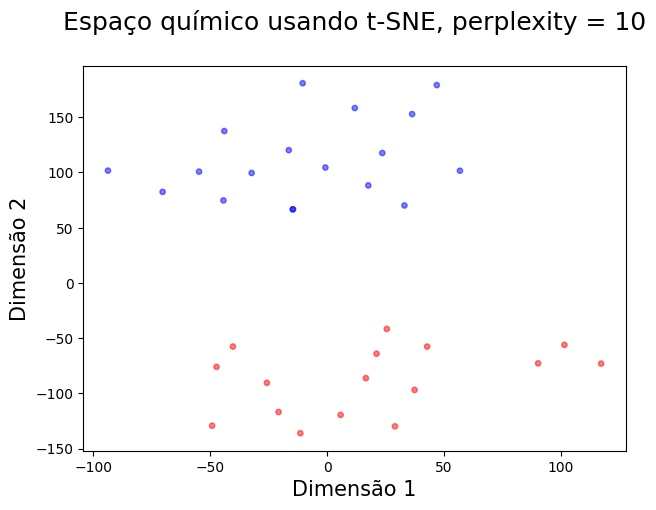

In [33]:
for perplexity in perplexities:
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate="auto",
        metric="euclidean",
        init="pca",
        random_state=0
    )
    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(7,5))
    plt.scatter(X_tsne[:,0], X_tsne[:,1], s=15, c=cores, alpha=0.5)
    plt.title(f'Espaço químico usando t-SNE, perplexity = {str(perplexity)}\n', fontsize=18)
    plt.xlabel('Dimensão 1', fontsize=15)
    plt.ylabel('Dimensão 2', fontsize=15)
    plt.show()

### UMAP

In [34]:
n_neighbors_list = [2, 5, 10]

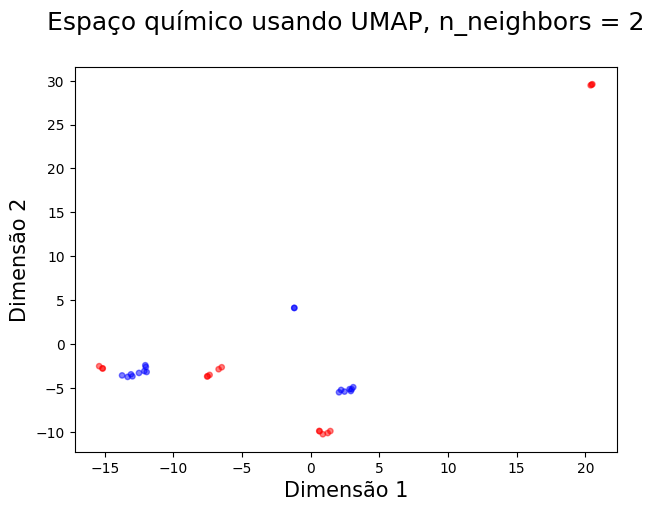

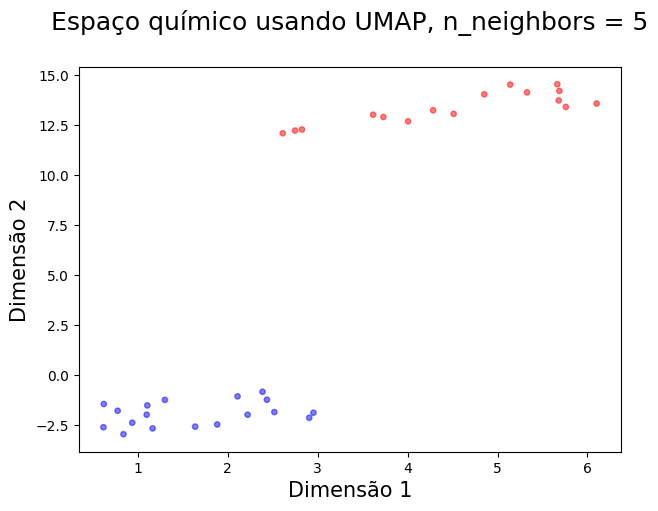

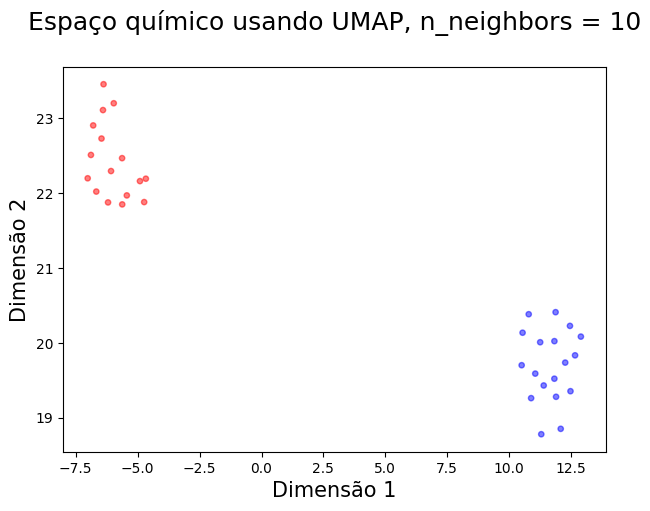

In [35]:
for n in n_neighbors_list:
    reducer = umap.UMAP(
        n_neighbors=n,
        n_components=2,
        metric="euclidean",
        init="spectral",
        random_state=0,
        n_jobs=1
    )
    X_umap = reducer.fit_transform(X)

    plt.figure(figsize=(7,5))
    plt.scatter(X_umap[:,0], X_umap[:,1], s=15, c=cores, alpha=0.5)
    plt.title(f'Espaço químico usando UMAP, n_neighbors = {str(n)}\n', fontsize=18)
    plt.xlabel('Dimensão 1', fontsize=15)
    plt.ylabel('Dimensão 2', fontsize=15)
    plt.show()

Note que, com mais informação disponível, as projeções conseguem captar melhor a semelhança entre os compostos de uma mesma classe, e diversas das projeções resultantes separam corretamente as duas classes. Nesse caso, um modelo de aprendizado de máquina que usasse esses mais de 200 descritores certamente seria capaz de atingir métricas muito altas. Note, porém, que o número de amostras é pequeno, portanto, um modelo usando todos esses descritores provavelmente sofreria de sobreajuste (*overfitting*).

# Espaço químico - *fingerprints*

Como os vetores são binários, não é necessário normalizar o conjunto de dados.

In [36]:
# Remover linhas com erro no cálculo dos fingerprints, caso existam
df_fps = df_fps.dropna(axis='rows')

In [37]:
X = df_fps.copy()

### PCA

O método PCA não é um método de redução de dimensionalidade apropriado para *fingerprints* moleculares, já que para a distância Euclidiana, dois *bits* iguais a 0 têm o mesmo peso que dois bits iguais a 1, ou seja, a ausência de uma subestrutura em duas moléculas tem o mesmo peso que a presença em ambas. Ainda que tal consideração possa ser matematicamente razoável, do ponto de vista químico, consideramos similares moléculas que compartilham subestruturas. Vamos manter o gráfico usando PCA para consistência, mas lembre-se sempre dessa limitação.

In [38]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

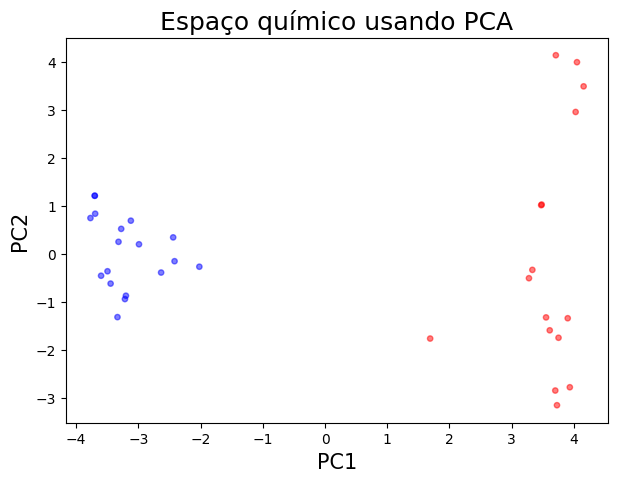

In [39]:
# Plot
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=15, c=cores, alpha=0.5)
plt.title('Espaço químico usando PCA', fontsize=18)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.show()

### MDS

Para *fingerprints*, cuja similaridade é usualmente medida pelo índice de Jaccard (ou índice de Tanimoto), devemos usar o método diretamente na matriz de dissimilaridades pré-computada (dissimilaridade = 1 - Tanimoto).

Note que o cálculo de todas as distâncias pode levar muito tempo, e o método MDS não costuma fornecer as projeções mais informativas. Dessa forma, incluo o código abaixo apenas para demonstração, mas não recomendo o uso do método MDS para *fingerprints*.

In [40]:
# Pré-calcular matriz de dissimilaridades
# Do Notebook https://github.com/rflameiro/Python_e_Quiminformatica/blob/main/Quiminformatica/Clustering%20(Agrupamento).ipynb
from rdkit.Chem import AllChem

fps = [mfpgen.GetFingerprint(x) for x in df["rdkit_mol"]]

n = len(fps)
dist_mat = np.zeros((len(fps), len(fps)))

# Como a matriz é simétrica, podemos calcular apenas metade:
for i in range(n):
    for j in range(i):
        sim = AllChem.DataStructs.TanimotoSimilarity(fps[i], fps[j])
        dist = 1 - sim
        dist_mat[i][j] = dist

# E preencher o restante usando a matriz transposta
# Note que a diagonal permanece preenchida por zeros
# já que a distância entre um ponto e ele próprio é zero
dist_mat = dist_mat + dist_mat.T

In [41]:
mds = MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    dissimilarity="precomputed",
    normalized_stress="auto",
    random_state=0)

X_mds = mds.fit_transform(dist_mat)

In [42]:
# valor final do stress
mds.stress_

27.101793293962267

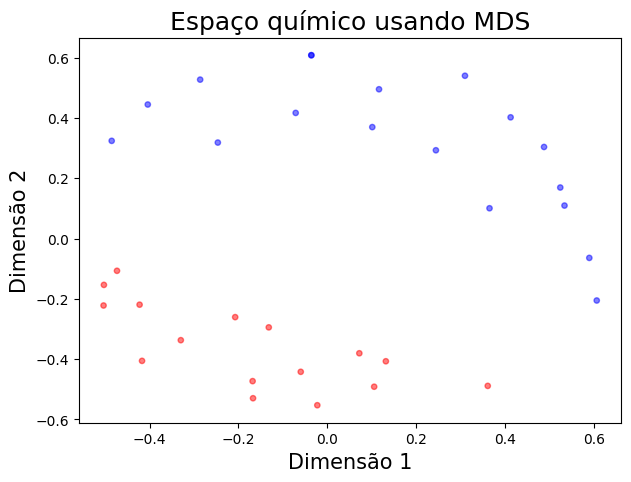

In [43]:
# Plot
plt.figure(figsize=(7,5))
plt.scatter(X_mds[:,0], X_mds[:,1], s=15, c=cores, alpha=0.5)
plt.title('Espaço químico usando MDS', fontsize=18)
plt.xlabel('Dimensão 1', fontsize=15)
plt.ylabel('Dimensão 2', fontsize=15)
plt.show()

### t-SNE

Note o uso de `metric="jaccard"`.

In [44]:
perplexities = [2, 5, 10]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


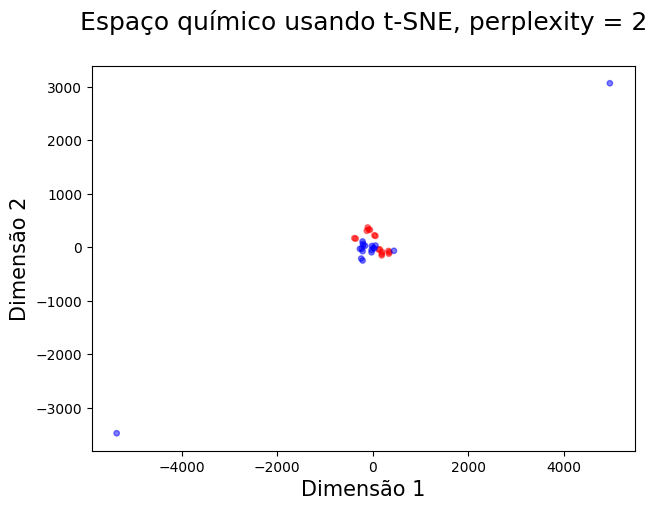

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


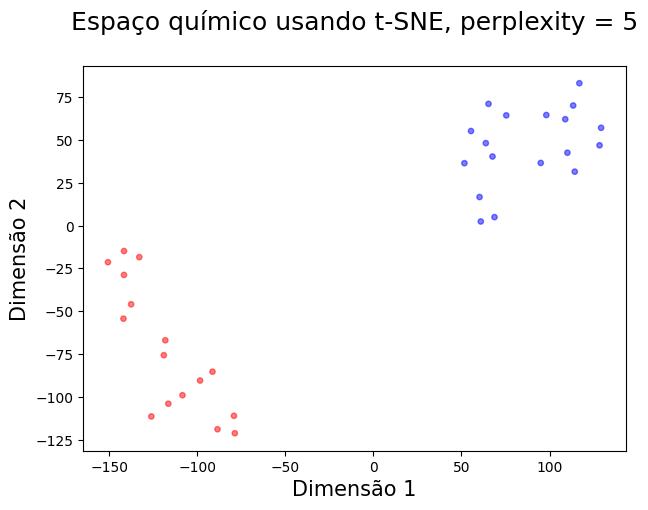

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


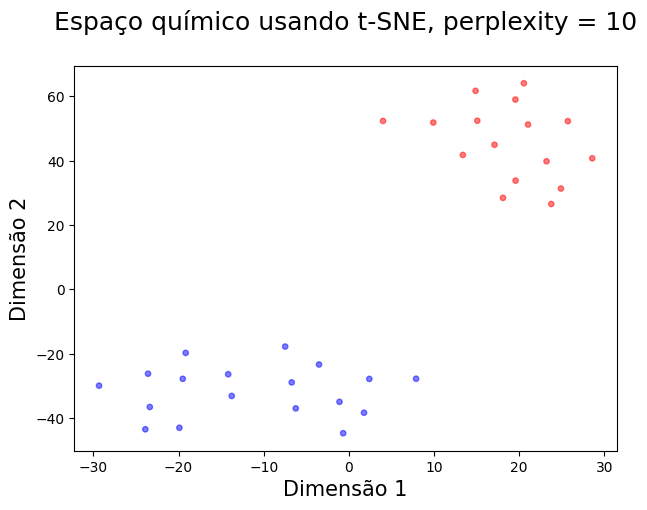

In [45]:
for perplexity in perplexities:
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate="auto",
        metric="jaccard",
        init="pca",
        random_state=0
    )
    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(7,5))
    plt.scatter(X_tsne[:,0], X_tsne[:,1], s=15, c=cores, alpha=0.5)
    plt.title(f'Espaço químico usando t-SNE, perplexity = {str(perplexity)}\n', fontsize=18)
    plt.xlabel('Dimensão 1', fontsize=15)
    plt.ylabel('Dimensão 2', fontsize=15)
    plt.show()

O `DataConversionWarning` indica apenas que os dados foram convertidos de numéricos (0/1) para booleanos (True/False) para o cálculo do índice de Tanimoto.

### UMAP

O método UMAP pode apresentar problemas quando um ou mais pontos são separados ao máximo de todos os outros pontos (em um conjunto de *fingerprints*, por exemplo, isso pode ocorrer quando um *fingerprint* não compartilha nenhum dos bits ativos com os outros compostos do banco de dados). Nesses casos, um dos pré-requisitos do método não é cumprido, e a estrutura interna da projeção é destruída. Para que isso não ocorra, os autores do método introduziram o parâmetro `disconnection_distance`, que pode ser modificado para lidar com a presença de amostras extremas.

In [46]:
n_neighbors_list = [2, 5, 10]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


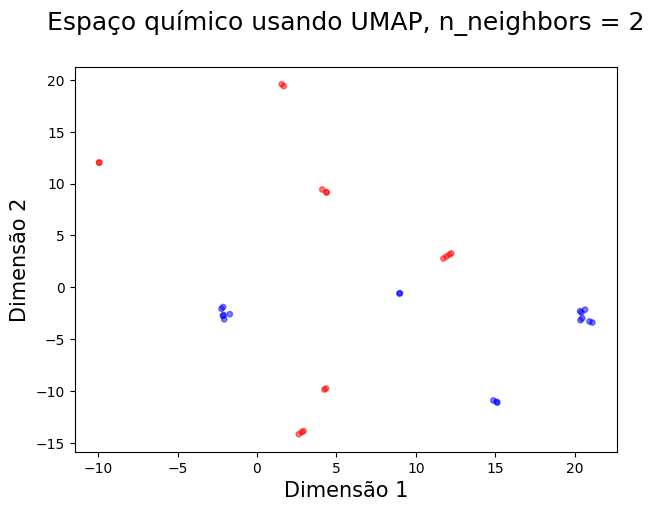

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


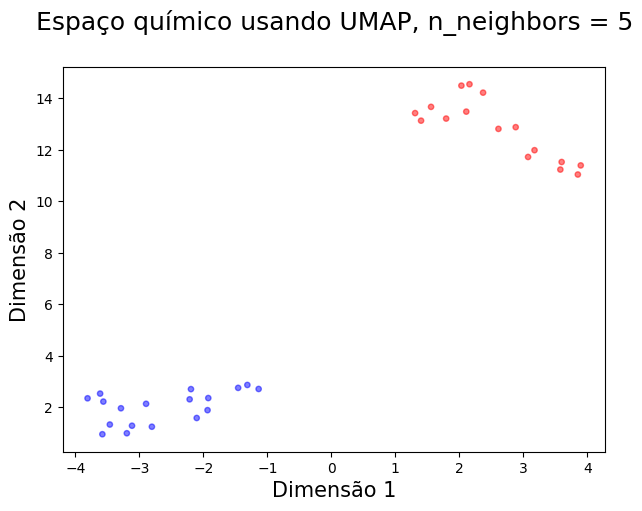

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


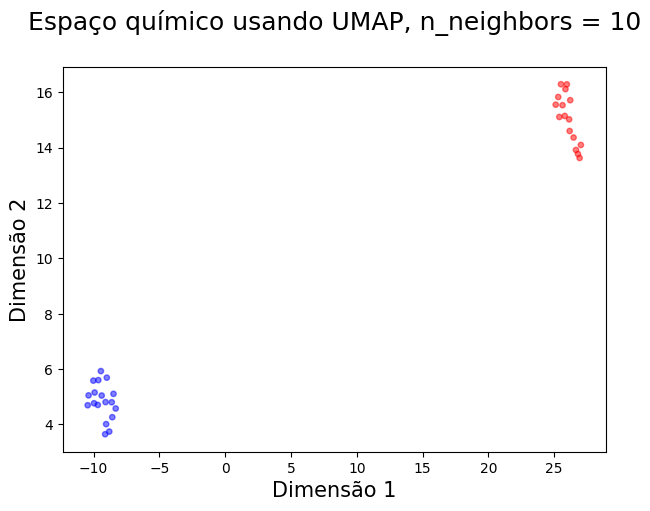

In [47]:
for n in n_neighbors_list:
    reducer = umap.UMAP(
        n_neighbors=n,
        n_components=2,
        metric="jaccard",
        init="spectral",
        random_state=0,
        n_jobs=1
    )
    X_umap = reducer.fit_transform(X)

    plt.figure(figsize=(7,5))
    plt.scatter(X_umap[:,0], X_umap[:,1], s=15, c=cores, alpha=0.5)
    plt.title(f'Espaço químico usando UMAP, n_neighbors = {str(n)}\n', fontsize=18)
    plt.xlabel('Dimensão 1', fontsize=15)
    plt.ylabel('Dimensão 2', fontsize=15)
    plt.show()

O mesmo fenômeno observado com os descritores ocorre aqui: como os *fingerprints* são vetores grandes (1024 dimensões), há muita informação disponível, e os compostos se agrupam de acordo com as classes esperadas.

# Fontes consultadas

Além das fontes citadas no texto, reutilizei o código [deste artigo](https://chemistry-europe.onlinelibrary.wiley.com/doi/abs/10.1002/cmdc.202200434), e alguns trechos foram extraídos da minha dissertação de qualificação.